## Introduction
This notebook shows a correlation-based approach to multi-channel voice activity detection on Sloan Fellow dataset without too much thresholding nor assuming only one speaker at a time.

**Existing methods**
- Threshold based classification rule
    - Hard to find a threshold to separate noise and speech for different environments

- Multi-class classification
    - Hard to adapt to scenarios without training data
    - Cannot extract all the features due to the undersampled (low resolution) data

- Blind source separation 
    - ICA assumes stationary mixing, i.e, requires subjects to remain fixed at locations, which are not always satisfied since in some cases subject may need to walk around and show some demos.
    - Hard to set thresholds to separate speech and noise on the demixed signal, which are not resilient to different environments.


**Important definitions**  
- *local speech* : The badge signal comes from the wearer.  
- *crosstalk* : The badge signal comes from other people nearby.  
- *frame*: a basic time unit of the signal (set to 1 second herein).

In [1]:
import warnings
warnings.filterwarnings('ignore')

## plot settings
# import mpld3
# mpld3.disable_notebook()
import matplotlib.pyplot as plt
%matplotlib inline
# plt.rcParams["figure.dpi"] = 80
## Important property! especially for speaking plot.
plt.rcParams["lines.solid_capstyle"] ="butt"
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}
matplotlib.rc('font', **font)
import seaborn as sns
fsl, fsm, fss = (30,15), (30,12), (20,10)

import pandas as pd
import scipy.stats as stats
import numpy as np
import os,sys
import itertools 
import datetime
import scipy.signal as signal

# load self-defined function 
from openbadge_analysis.preprocessing.audio import *
from openbadge_analysis.core import  *
from openbadge_analysis.visualization.audio_visualization import *

## The data

In [2]:
input_file_name = '../data/meeting_data/two_speakers.txt' #two speakers

df_meeting = sample2data(input_file_name)
metadata = {}
metadata.update(df_meeting.metadata)
df_meeting=pd.pivot_table(df_meeting.reset_index(),index='datetime',
                          columns='member',values='signal').fillna(value=0)
# df_flt = get_meet_flt(df_meeting)
df_flt = df_meeting

metadata['description']

u"Experiment 12. I'm wearing badge 1 . all badges are arranges in a square formation 3 ft away from each other. I'm speaking at regular intervals. b2 with fman 4 ft away in front , b4 on my left and b3 in behind. Speak at regular intervals"

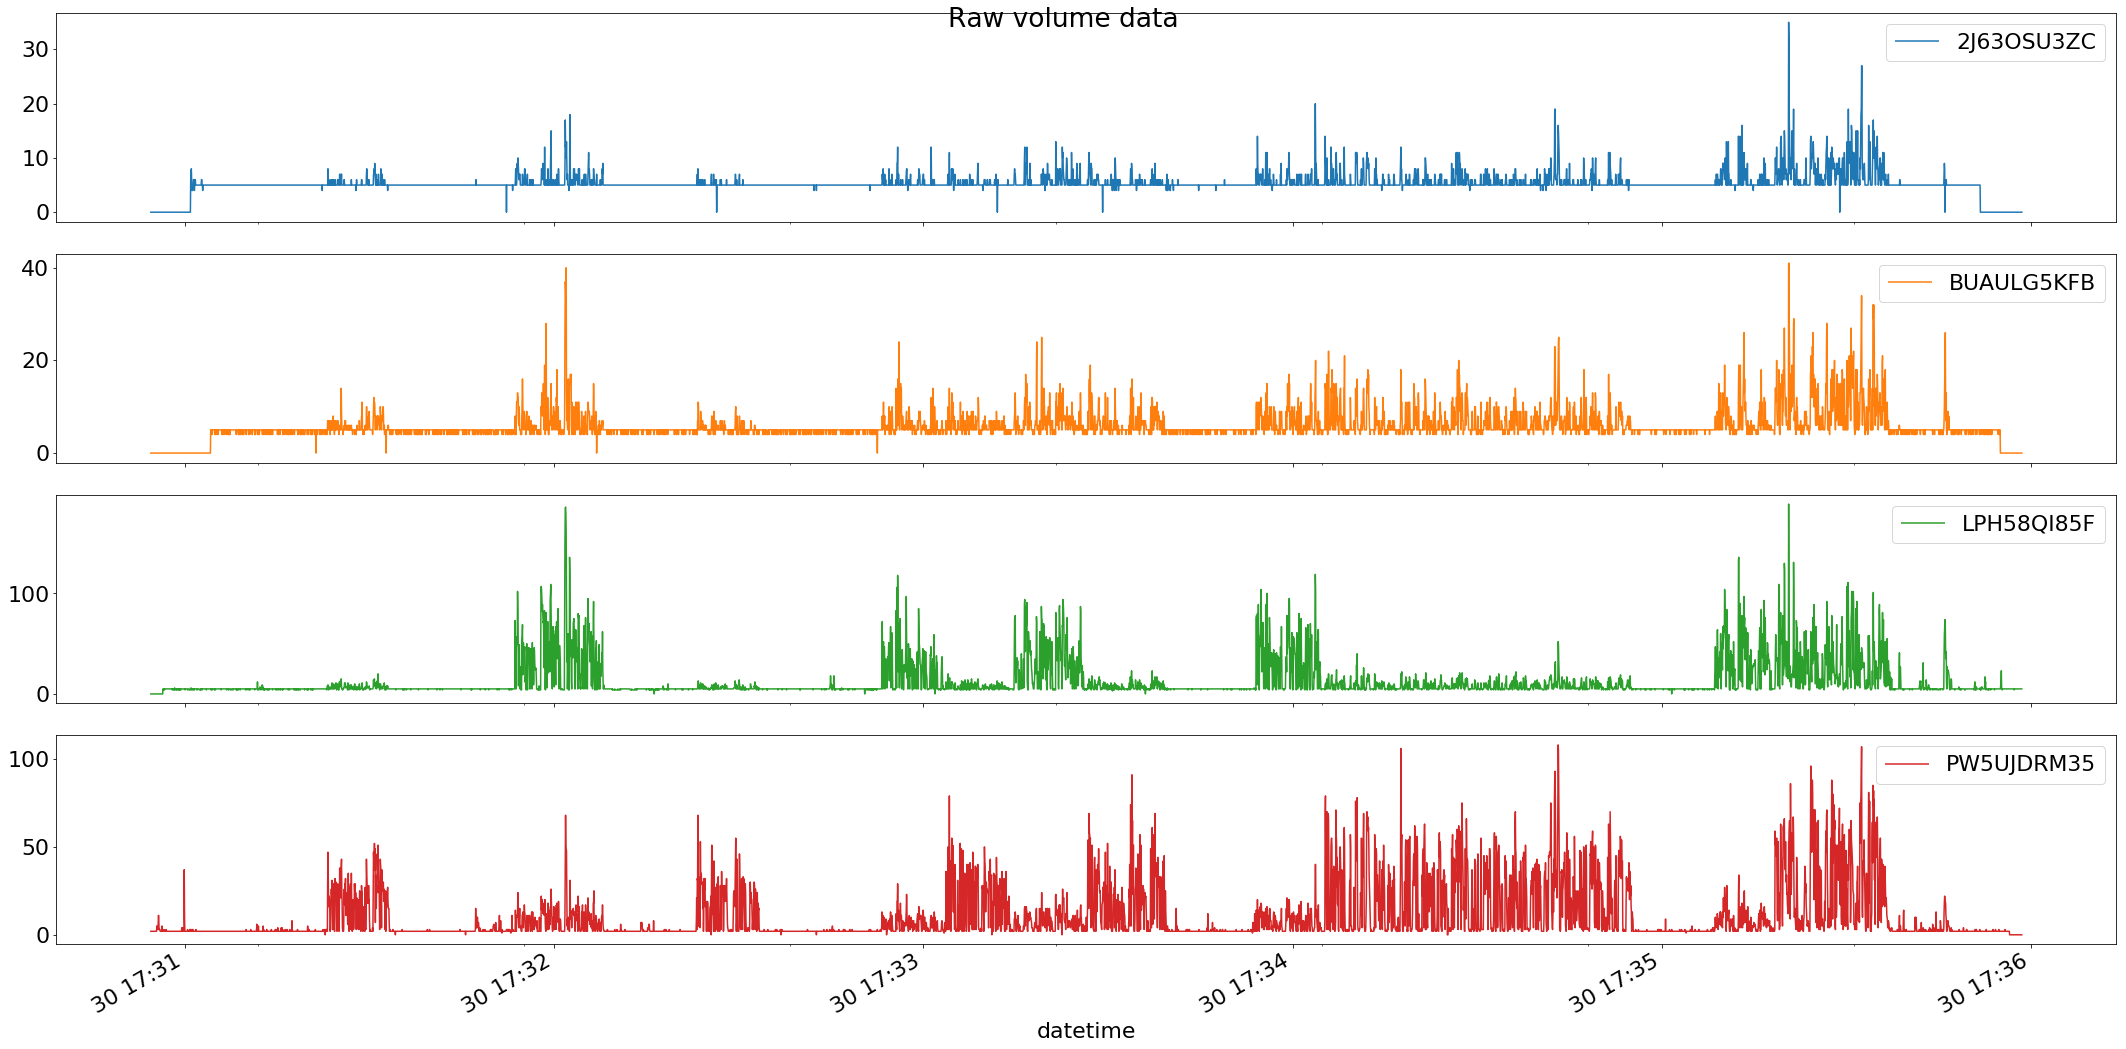

In [3]:
df_meeting.plot(subplots=True, figsize=fsl, title='Raw volume data')
plt.tight_layout()

## Observation of heuristics
> **When only one person speaks, other people's badge signals are highly correlated with the speaker's badge signal.**

This can be easily understood by a simple case study. Assume the simplest case with two speakers.

<!-- $$A = X + \rho \cdot Y + \phi$$
$$B = Y +\rho \cdot X + \phi,$$
where $A$ stands for the measured signal from badge A, $X$ is the voice signal from person A, $\rho$ is the attenuation ratio, and $\phi$ is a combined noise of background and device noises.
-->

When person A talks with B keeps silent:
$$A = X + \phi \approx X$$
$$B = \rho \cdot X + \phi \approx \rho \cdot X$$
Also $\phi$ is usually much smaller than $X$, therefore $A$ and $B$ are highly correlated.

In the following figure, we show data from two users, and mark the frames that have high correlation. As we can see from the data, when there is a single speaker, there is high correlation.

"# high correlation" is a measurement of frames when the voice signals' correlation of selected users are larger or equal than a threshold.

This metrics is useful for choosing the parameter `window`. More details can be found in [here](#window).

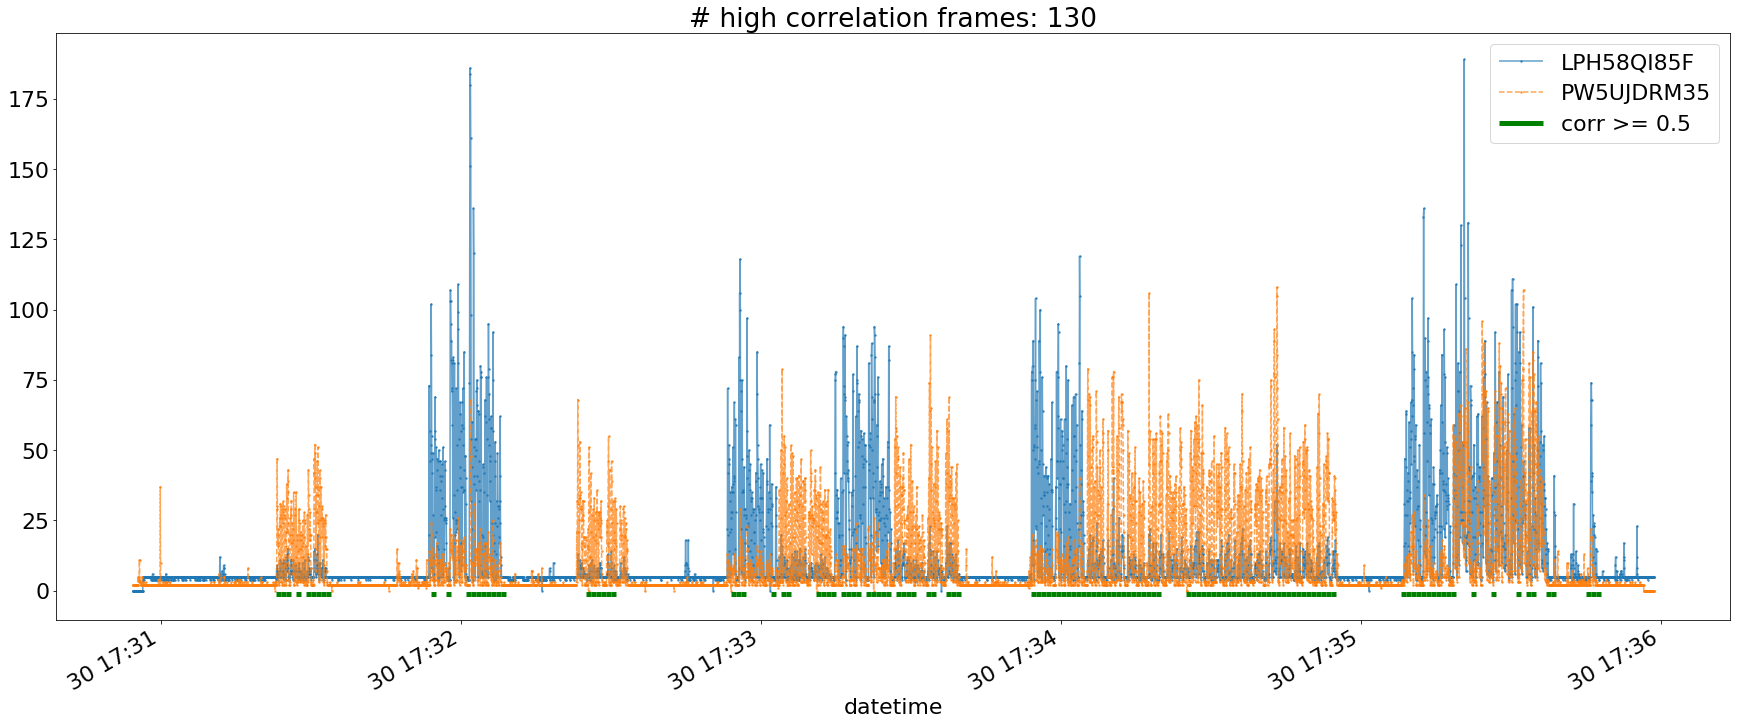

In [5]:
sel_users = df_flt.columns[[2,3]]
plot_raw_cor(df_meeting, sel_users=sel_users, figsize=fsm);

## Detecting speakers

### Overview

**Main idea**  
First, we have a key observation of heuristic that enables us to find a subset of frames when only one local speech exists. Then, based on these frames, we extract classification rules for each subject and find all frames that these subjects are likely to speak. Finally, we exploit the correlation again to filter out false speaker that are caused by crosstalk.

**Steps**  
The detection consists of three steps each of which needs to iterate the whole signal once.
<ol>
<li> Find a subset of frames when only one local speech exits. (we call **Genuine spk**)</li>
<li> Find all frames when subjects are likely to speak. (**All spk**)</li>
<li> Remove frames that are actually caused by crosstalk. (**Real spk**)</li>
</ol>

### Parameter setting
We have three (maybe two) parameter for this method. All of them we have ways to automatically select appropriate even the best values. The selection of parameters are discussed [here](#Parameter-selection).

- `window` (optional): window size for filtering
- `thre`: correlation threshold to find genuine spk
- `bandwidth`: [KDE](https://en.wikipedia.org/wiki/Kernel_density_estimation) smoothing parameter.

In [6]:
# correlation thre. How to choose the value is stated afterwards.
thre = 0.4

# This parameter could be optimized but could be slow. Therefore, we emperically determined the value.
bandwidth=1.8

# for preprocessing with median filter
window=8

# figure sizes
fsl, fsm, fss = (18,10), (18,6), (12,6)

### Preprocessing
Preprocessing is a common step of VAD which filters out noises from the voice signal.

However, I think this step might be unnecessary here for two reasons.
- The data collection (use the mean value to represent a small range of voice data) itself resembles mean filter. So preprocessing might be redundant here.
- Excessive filtering will alter the original data too much and thus destroy the correlation within the signal. After all, our method heavily relies the correlation.

But I am not quite sure since the results are not comparable, maybe we need to verify this with a benchmark.

In [7]:
df_flt = df_meeting
## uncomment this line to do filtering
# df_flt = get_meet_flt(df_meeting, window=8)

### Find genuine spk
**What**  
Motivated by our observation, we can find a subset of frames when only one local speech exists.

**How**  
The selection criteria is as follows.
- The correlation of the rest people's signals with the subject must be no less than `thre`.
- The mean volume of the subject must be the highest.

**Why**
- High correlations with all other people indicate crosstalk.
- Highest volume indicates the subject generates the local speech and causes the crosstalk.

In [8]:
df_spk_mean, df_spk_std = get_spk_genuine(df_flt, thre)

From the 5th subplot of the figure below ("Genuine spk"), we can see that some time slots are highlighted. Those slots are identified as there are only one local speech exists.

('2016-06-30 17:30:54', '2016-06-30 17:35:54')

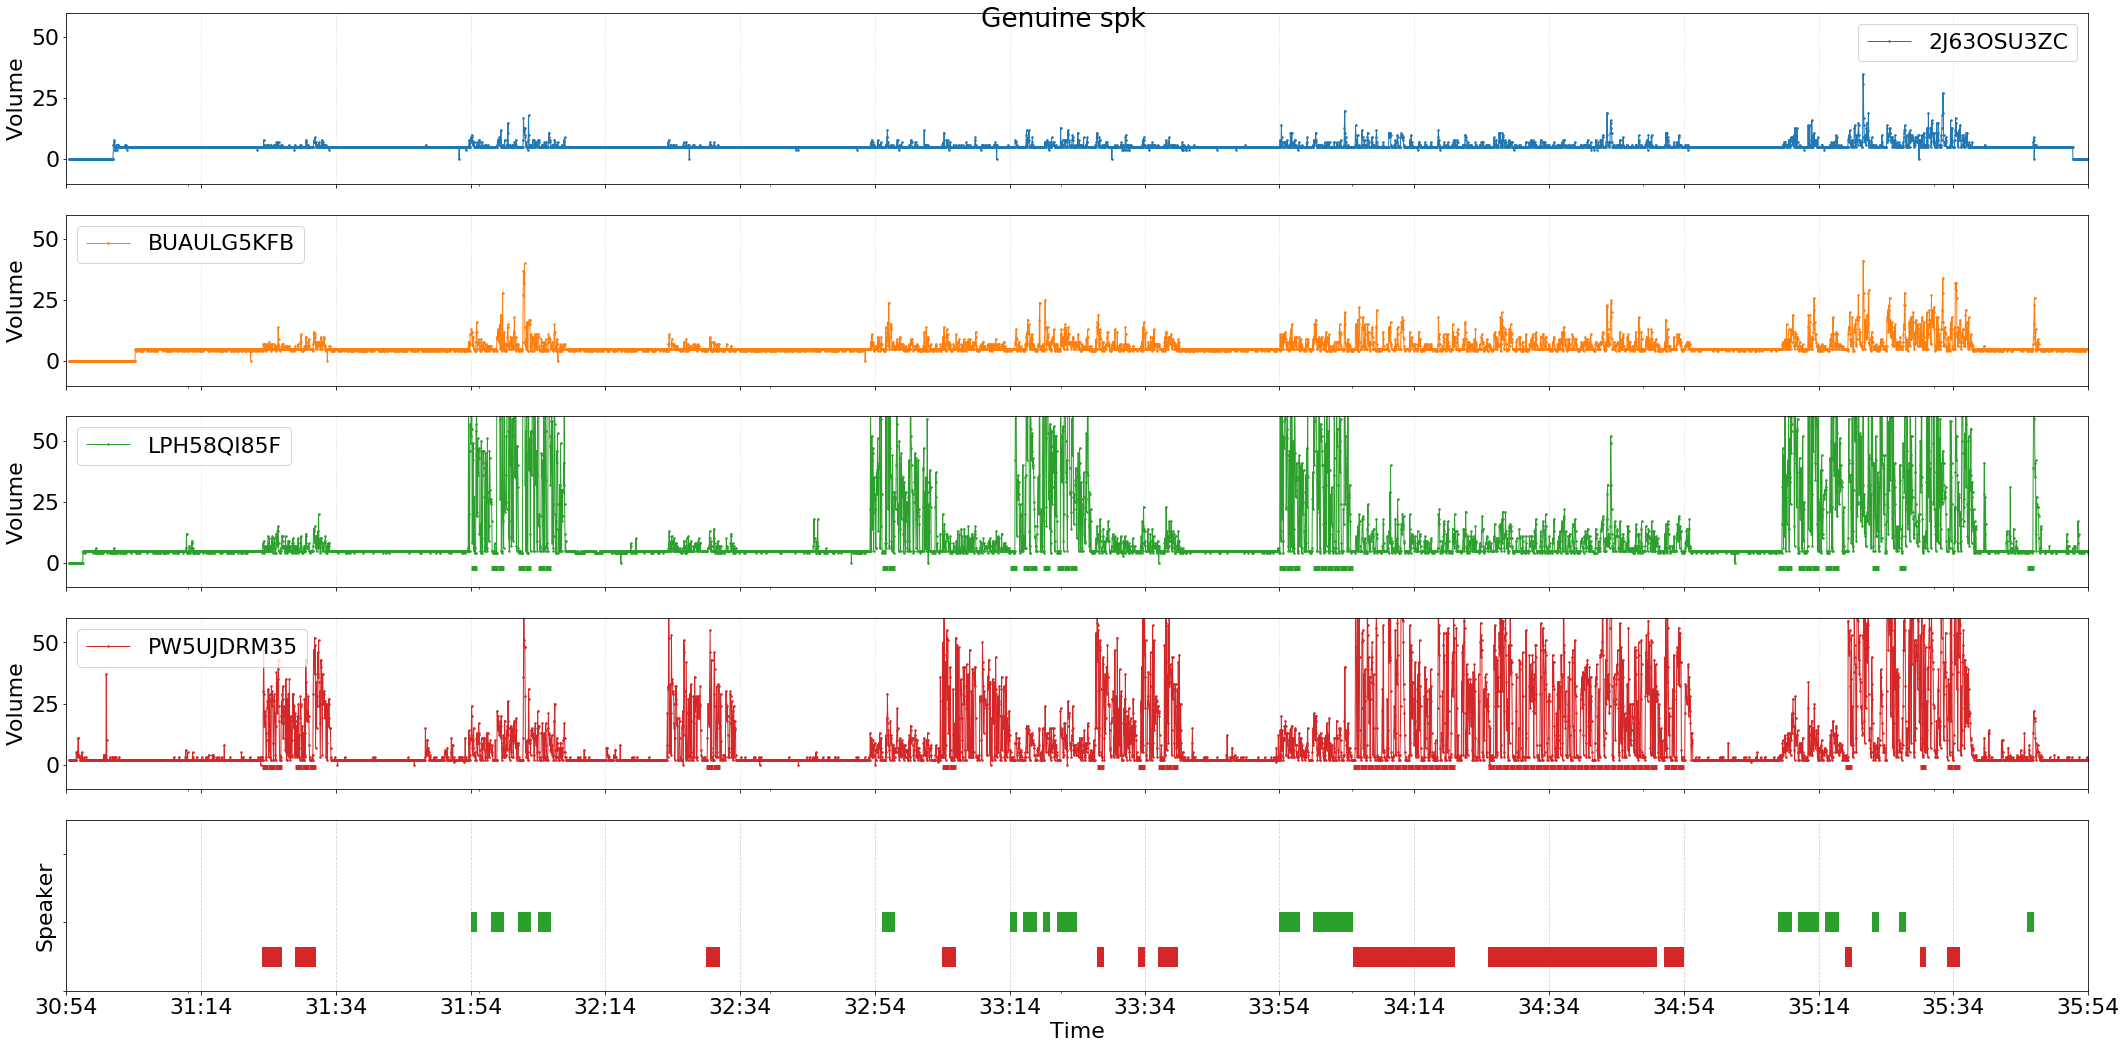

In [9]:
plot_spk(df_flt, df_spk_mean, dur=60*5, interval=20, title='Genuine spk', 
         show_std=False, show_trace=False)

<!-- ### Find all spk
**What**  
Find all frames when subjects are "likely to speak" using the classification rules extracted from genuine spk. 
We iterate all frames for each subject, if the feature of a subject's frame satisfy his rule, then he is supposed to speak.

**How**  
When we say the subject are likely to speak, it is actually caused by two situations.
- Situation I: local speech / or local speech + crosstalk
- Situation II: crosstalk 

For both situations, we can extract features from every time slots and generate two distribution ($D_t $and $D_s$). Here the features are "mean of volume" and "std of volume".

Then we can find a separating value to best distinguish $D_t$ and $D_s$ and apply the separating value to raw signal to find all time slots where the are likely to speak.

**Why**  
- Different people have different voice features. With this methods, we can know how their voice features look like with the distributions. 
- We can treat this as a binary classification problem, we need to find a separating value to distinguis the two classes. 
- The separating value where two distribution intersects can maximize **true positive** and **false positive** rate. -->

### Find all spk
**What**  
Find all frames when subjects are "likely to speak" using the classification rules extracted from genuine spk. 
We iterate all frames for each subject, if the feature of a subject's frame satisfy his rule, then he is supposed to speak.

**How**  
The key point relies on how to extract the classification rules from genuine spk. We have two rules: if either "mean of volume" or "std of volume" of the frame satisfy its cut-off point, we regard the subject is likely to speak.

The extraction of "mean of volume" classification rules for subject $s_i$ is as follows, which is also similar to that of "std of volume".
Given all frames in genuine spk, we can generate two distributions for $s_i$, $D_t(i)$ (distribution of mean volume when $s_i$ talks), $D_s(i)$ (distribution of mean volume when $s_i$ keeps silent).

Usually, $D_t(i)$ and $D_s(i)$ overlap to some extent. When different cut-off points are used to separate them, it will derive different results. 

If we treat this as a binary classification problem as illustrated below, we will get different true positive rate and true negative rate. How to choose the cut-off point depends on our objective. 
We can do different optimizations here, but their performance are hard to compare with manually.
Here I use a rule-of-thumb to choose the intersection of both distributions as the cut-off point.
The figures below shows how the cut-off points are selected. Note that the top-right and bottom-right figures show data from two silent badges.

**Why**  
- Different people have different voice features. With this methods, we can know better how their voice features look like with the distributions. 

([5.1727393178535159, 2.9287750745285477], array([ 13.8,  13.5,  13.2,  13.5]))

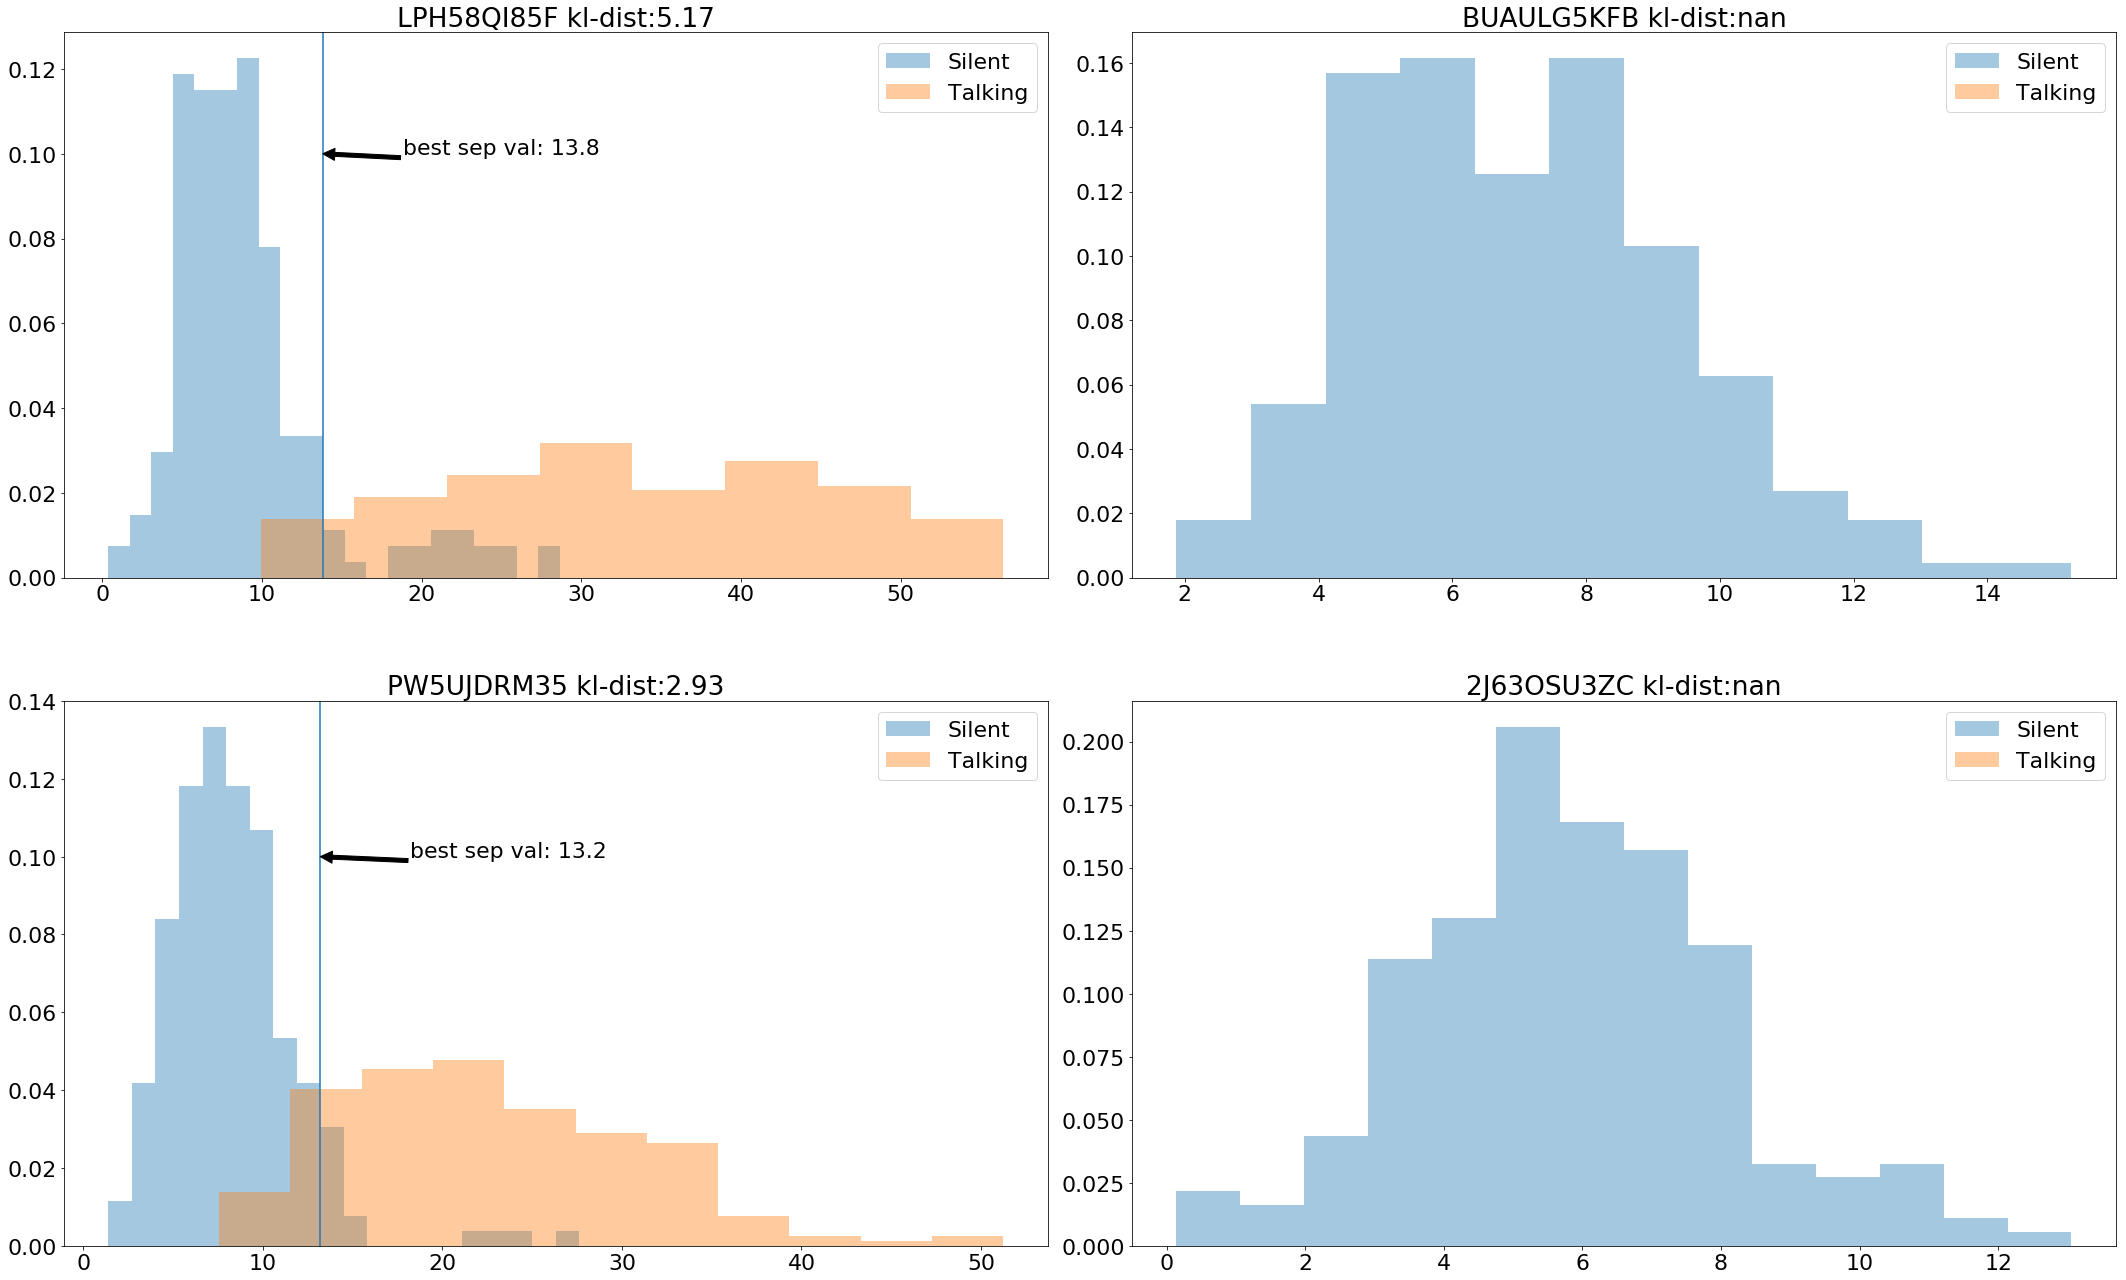

In [10]:
nys_mean = get_ts_distribution(df_flt, df_spk_mean)
get_kldistance(nys_mean, plot=True, figsize=(30, 18), bandwidth=bandwidth)

In [11]:
## 2nd-pass. Calculates the cutoff points, and find allspk
df_spk_all, seps_mean, seps_std= get_spk_all(df_flt, df_spk_mean, df_spk_std)

('2016-06-30 17:30:54', '2016-06-30 17:35:54')

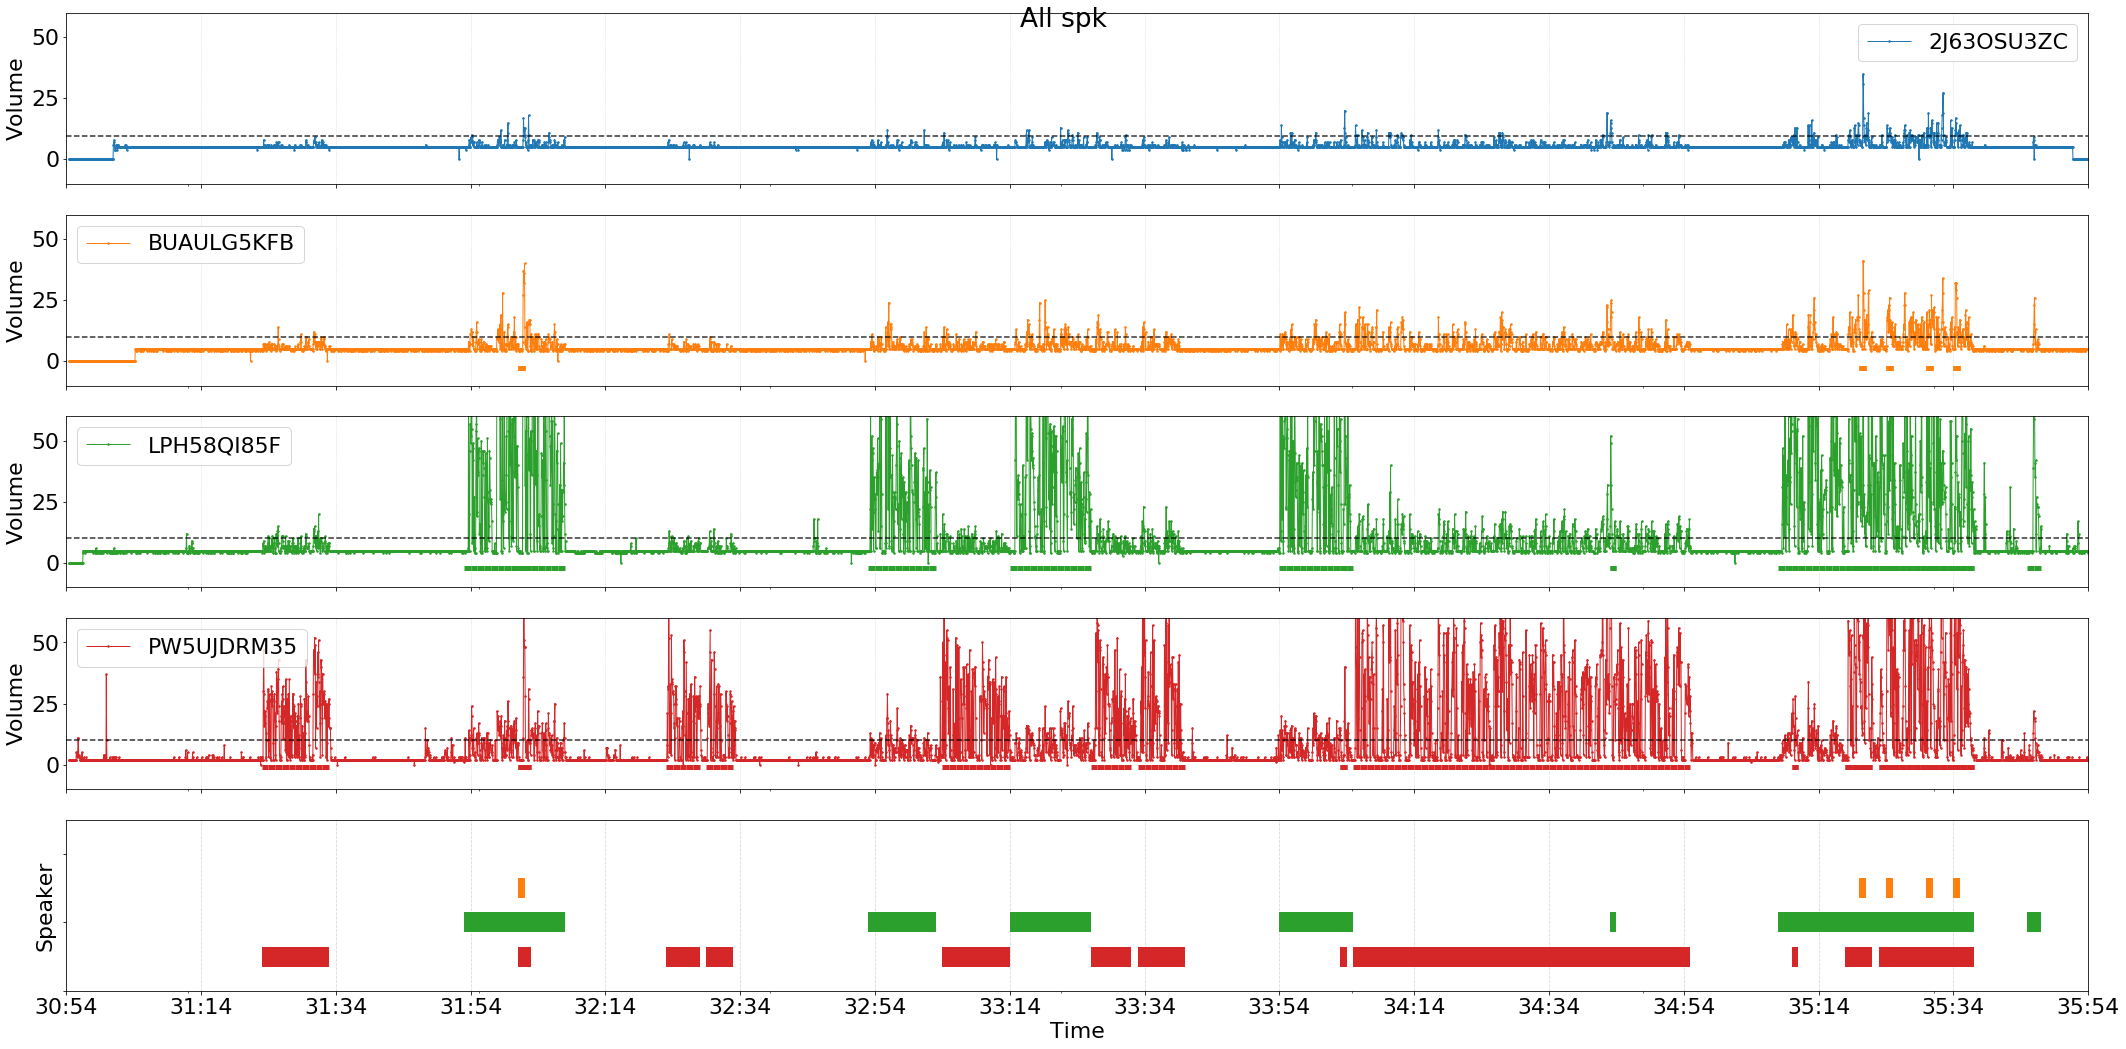

In [12]:
plot_spk(df_flt, df_spk_all, seps_std, dur=60*5, interval=20, title='All spk', 
         show_std=False, show_trace=False)

### Find real spk
**What**   
When we say the subject is likely to speak, it is actually caused by two situations.
- Situation I: local speech or local speech + crosstalk
- Situation II: crosstalk 

This step is to eliminate Situation II for all frames when multiple speakers exist.

**How**  
Given a frame with multiple detected speakers. For all pairwise "speakers", if their correlation is no less than `thre` (that means that there is high correlation), the speaker with lower mean volume is regarded as caused by crosstalk.

**Why**  
- Generally speaking, voice signals from different people can be regarded as random independent variables. We assume their correlation obeys zero-mean Normal distribution (which means that the correlation will be low).
- High correlation indicates crosstalk.

In [13]:
## 3rd-pass 
df_spk_real = get_spk_real(df_flt, df_spk_all, thre)

('2016-06-30 17:30:54', '2016-06-30 17:35:54')

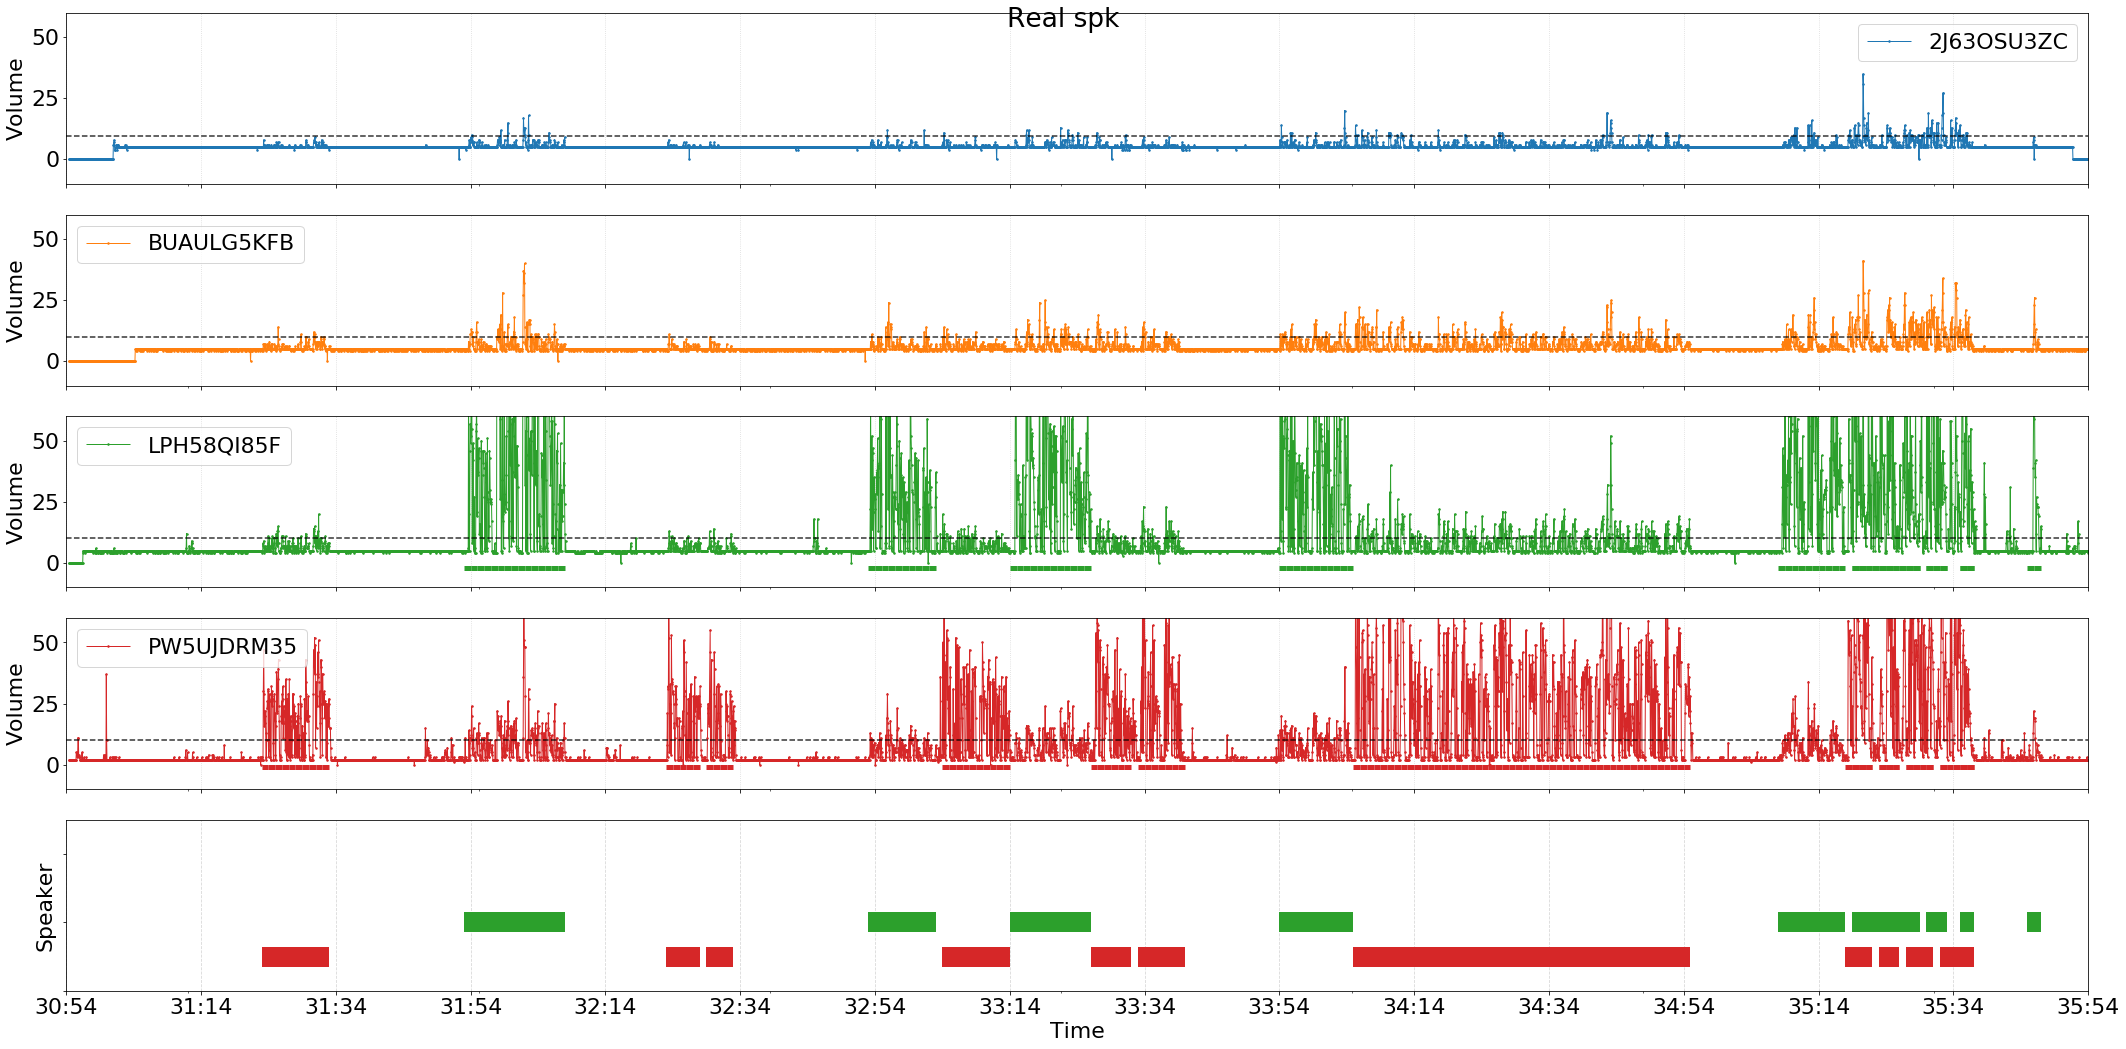

In [14]:
plot_spk(df_flt, df_spk_real, seps_std, dur=60*5, interval=20, title='Real spk', 
         show_std=False, show_trace=False)

### Parameter selection

#### window
`window` is the parameter for filtering raw volume signal.

As described above, the voice signal of different speakers are independent and mostly uncorrelated.

- Let $N_c$ be the true number of high-correlations time slots for all pairwise subjects.  
- Let $\hat{N}_c$ be the number we can find from the voice signal.   
- $\hat{N}_c \le N_c$ due to the existence of noise.  

The intuition is to find a `window` that can maximize the number of high-correlations time slots, i.e.,
$$\max_{window} \hat{N}_c$$


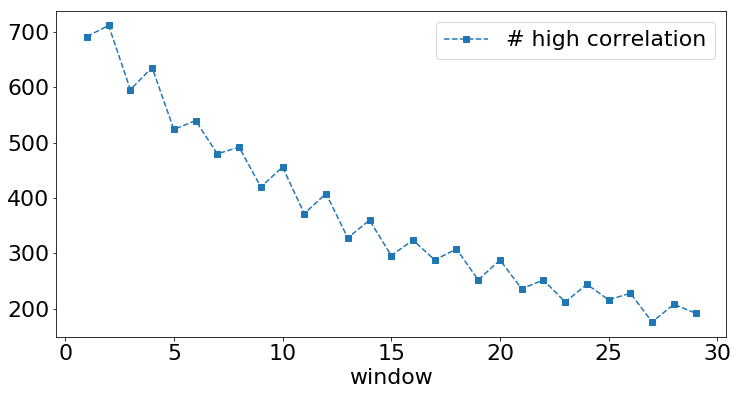

In [15]:
para_window(df_meeting, thre, figsize=fss)

#### thre
`thre` is a parameter of correlation threshold for finding genuine spk.

Different `thre` will generate various $(D_t, D_s)$. $D_t$ is the distribution of voice feature when a subject talks, $D_s$ stand for silence.

Different `thre` also has an impact of the size of genuine spk. The larger `thre` the fewer genuine spk we get. Significantly fewer genuine spk makes biased distributions.

The main idea is to find a thre that generate considerable genuine spk and 
$$\max_{thre}\mathcal{D}_{kl}(D_t, D_s)$$

$\mathcal{D}_{kl}(.,.)$ calculate the KL-divergence for both input distributions.

Yet, the sample data is too few (over 5 min with only two speakers) to appropriately show the relation...

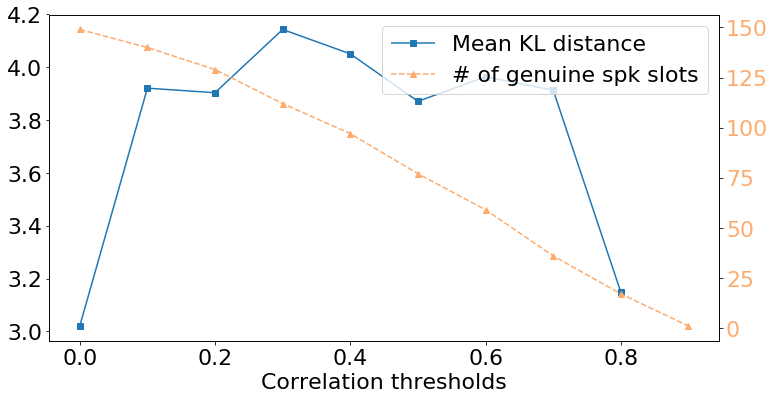

In [16]:
para_thre_cor(get_meet_flt(df_meeting, window=1), figsize=fss)

#### bandwidth
To calculate the kl distance or find the separating value, we need "distributions". Simply using histograms is impractical due bin shifting effect. Instead, we use kernel density estimation, a nonparametric way of esitmating probablity density function.

More infomation can be found: https://jakevdp.github.io/PythonDataScienceHandbook/05.13-kernel-density-estimation.html

Note: If `get_kde_pdf(optimize=True)`, cross-validating will be used to find the best bandwidth, the only problem is too slow. So we can use some rule of thumb to set the bandwidth.